<h1 style="font-size:2.5rem;color:purple;">Artificial Intelligence II</h1>
<h1 style="font-size:1.5rem;color:purple;">Deep Learning for Natural Language Processing (NLP)</h1>

In this assignment, we develop a sentiment classifier using only **Logistic Regression** and only **TF-IDF** in Python on a given Twitter dataset.  
The dataset consists of three files: *train_dataset.csv, val_dataset.csv, test_dataset.csv*.  
Train and Val consists of three columns: **ID, Text, Label**, and Test consists of two columns: **ID, Text**.

In [234]:
# Import libraries

import pandas as pd

import warnings

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter

import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

In [235]:
# Ingore warnings
warnings.filterwarnings("ignore")

First we load the given data (*test.csv* to use for training the model, *val.csv* to use for validation of training and *test.csv* to use for predictions)

In [236]:
# Read train dataset (to use for training)
df_train = pd.read_csv('datasets/train_dataset.csv')

# Read val dataset (to use for validation of training)
df_val = pd.read_csv('datasets/val_dataset.csv')

# Read test dataset (to use for predictions)
df_test = pd.read_csv('datasets/test_dataset.csv')

Let's take a look at the train dataset (the other two datasets have a similar structure to this one)

In [237]:
df_train

,ID,Text,Label
0,189385,@whoisralphie dude I'm so bummed ur leaving!,0
1,58036,"oh my god, a severed foot was foun in a wheely...",0
2,190139,I end up &quot;dog dialing&quot; sumtimes. Wha...,1
3,99313,@_rachelx meeeee toooooo!,0
4,157825,"I was hoping I could stay home and work today,...",0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i w...,0
148384,61015,another day gone by....time is moving so fast...,0
148385,36598,"fuck college, i'm just gonna marry rich. : fuc...",1
148386,83799,ZOMGZ NEW SONG FTW. remember that night. &lt;3,1


<h1 style="font-size:1.5rem;color:purple;">Data Preprocessing</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we clean the datasets.</h1>

First remove duplicate values, then remove unwanted symbols/characters (e.g. URLs, @mentions, numbers/characters) and convert every letter to lowercase.

In [238]:
# Drop duplicate values 
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_val = df_val.drop_duplicates().reset_index(drop=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)

Function to clean a text

In [239]:
# Function to clean text

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions/usernames
    text = re.sub(r'@\w+', '', text)
    # Remove numbers and characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()

    return text


# Clean only Text column
df_train['Text'] = df_train['Text'].apply(clean_text)
df_val['Text'] = df_val['Text'].apply(clean_text)
df_test['Text'] = df_train['Text'].apply(clean_text)

Drop rows with NaN values

In [240]:
# Drop NaN values
df_train = df_train.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_val = df_val.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_test = df_test.replace(r'^\s*$', pd.NA, regex=True).dropna()

Now take a look at the same dataset as above, but cleaned (the other two datasets are cleaned as well)

In [241]:
df_train

,ID,Text,Label
0,189385,dude im so bummed ur leaving,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes whats do...,1
3,99313,meeeee toooooo,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i w...,0
148384,61015,another day gone bytime is moving so fast,0
148385,36598,fuck college im just gonna marry rich fuck co...,1
148386,83799,zomgz new song ftw remember that night lt,1


Remove stopwords (this action keeps only the necessary words from a text and helps to ease the training of the model)

In [242]:
# Download stopwords
nltk.download('stopwords')

# Load english stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/christina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Function to remove stopwords from a text

In [243]:
# Function to remove stopwords from a text

def remove_stopwords(text):

    words = text.split()  # Separate text into words
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stopwords
    clean_text = ' '.join(filtered_words)  # Join separated words into a text
    return clean_text

Remove stopwords from all three datasets

In [244]:
df_train['Text'] = df_train['Text'].apply(remove_stopwords)
df_val['Text'] = df_val['Text'].apply(remove_stopwords)
df_test['Text'] = df_test['Text'].apply(remove_stopwords)

Drop rows with NaN values (some rows may be empty after removing stopwords)

In [245]:
# Drop NaN values
df_train = df_train.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_val = df_val.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_test = df_test.replace(r'^\s*$', pd.NA, regex=True).dropna()

Set word lemmatizer (this action transform words into their base or root forms)

In [246]:
# Create Lemmatizer
lemmatizer = WordNetLemmatizer()

Function for lemmatization in a text

In [247]:
# Function for lemmatization in a text

def lemmatize_text(text):
    words = text.split()  # Separate text into words
    lemmatized_text = " ".join([lemmatizer.lemmatize(word, pos="v") for word in words])  # Lemmatize words
    return lemmatized_text

Lemmatize every word in Text column of the dataframes

In [248]:
df_train['Text'] = df_train['Text'].apply(lemmatize_text)
df_val['Text'] = df_val['Text'].apply(lemmatize_text)
df_test['Text'] = df_test['Text'].apply(lemmatize_text)

Show Validation dataframe after lemmatization

In [249]:
df_val

,ID,Text,Label
0,187062,heyheyhey maybe get could find would cant find...,0
1,168997,work work crap miss condescend overbear presen...,0
2,194461,want trip boston next month need additl motiva...,1
3,165442,first day start tomorrow,1
4,34853,course fish little saigon dessert place coconu...,1
...,...,...,...
42391,52389,hello people back break howve youll,1
42392,64308,like cook food taste much better someone else ...,0
42393,199678,yeah one tell want without know much,1
42394,118713,cant seem dm bookseller events even next time ...,0


<h1 style="font-size:1.5rem;color:purple;">Analysis</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will try to visualize the data and their statistics.</h1>

Create some wordclouds to make it clear and visible which words are used more often

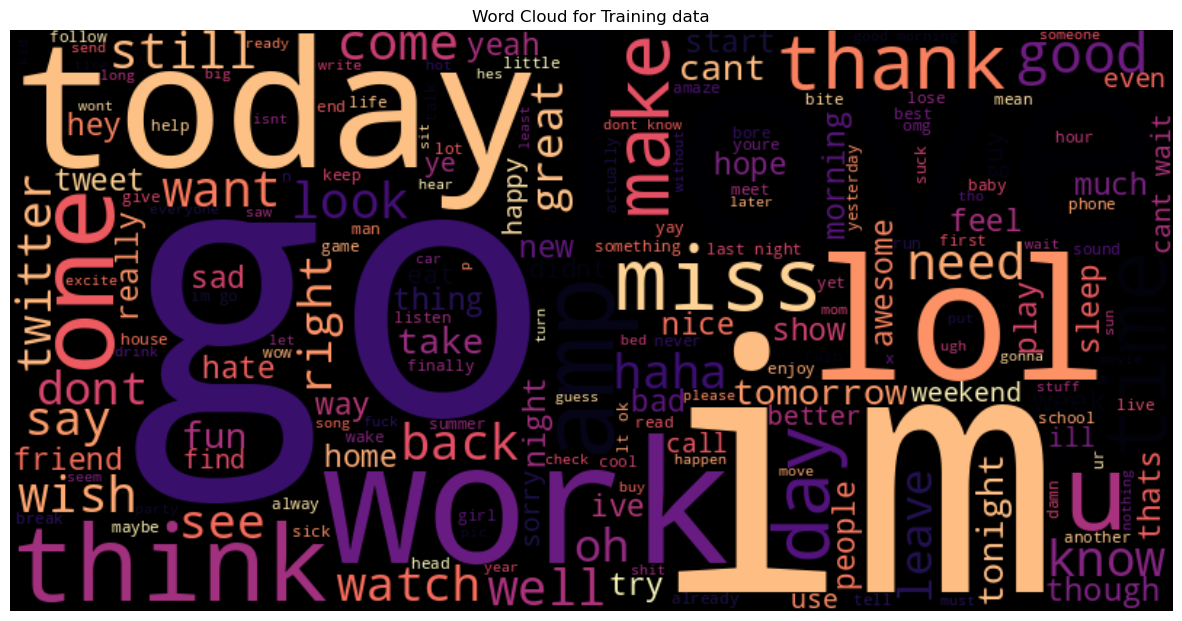

In [250]:
# Wordcloud for TRAINING DATA

# Combine all text entries into one string
text = " ".join(df_train['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Training data")
plt.axis("off")
plt.show()

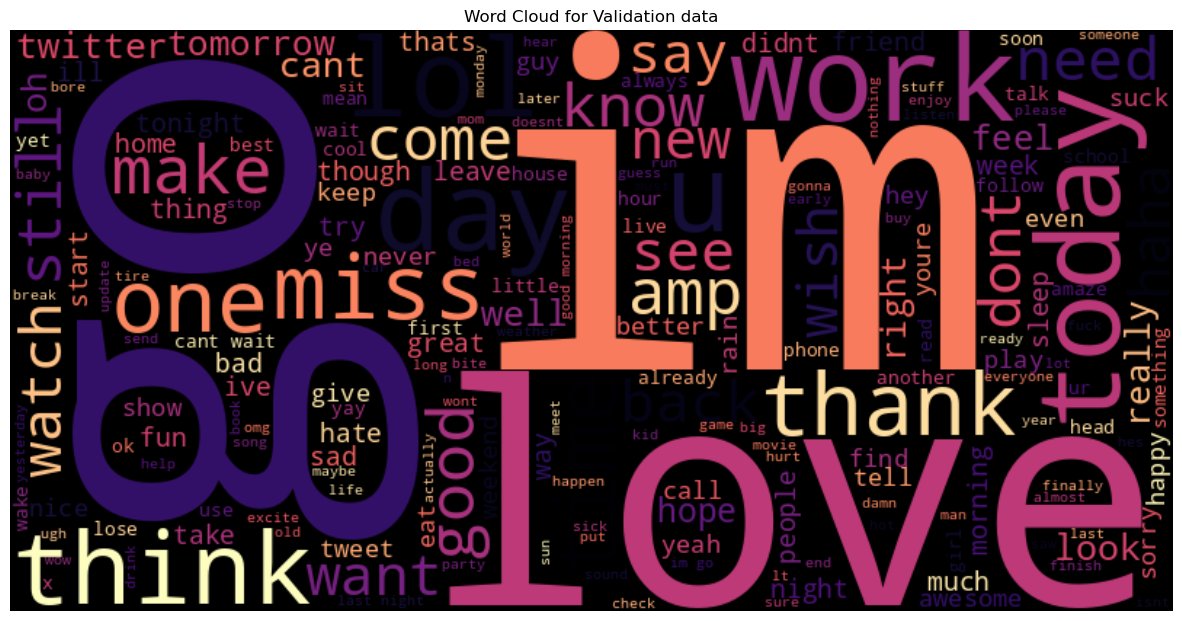

In [251]:
# Wordcloud for VALIDATION DATA

# Combine all text entries into one string
text = " ".join(df_val['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Validation data")
plt.axis("off")
plt.show()

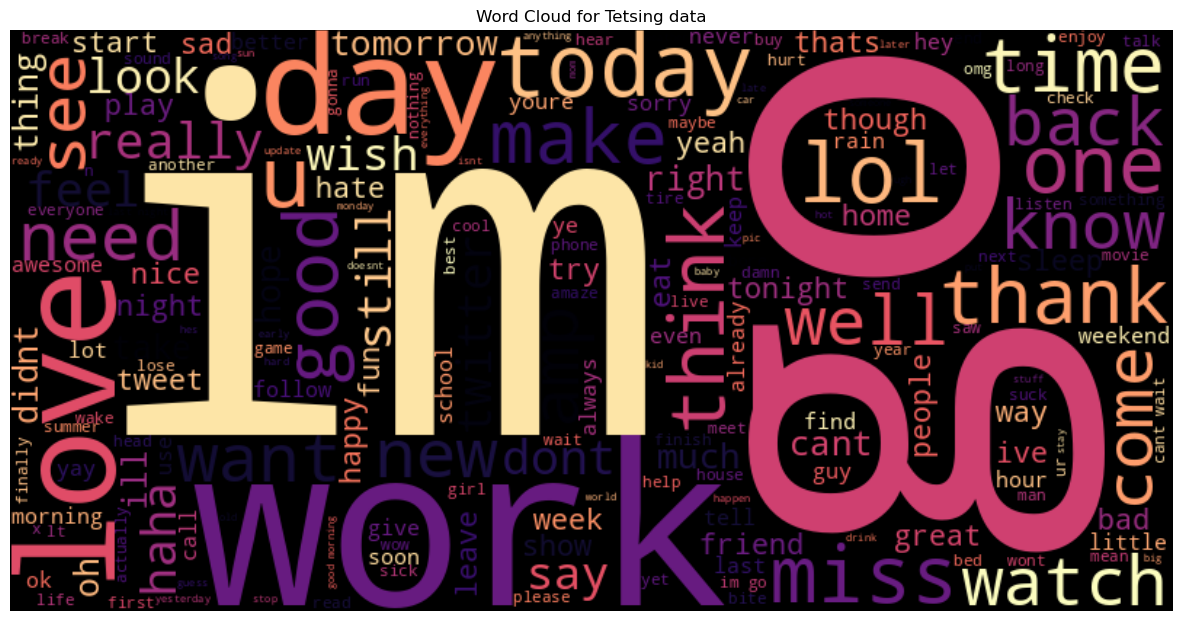

In [252]:
# Wordcloud for TESTING DATA

# Combine all text entries into one string
text = " ".join(df_test['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Tetsing data")
plt.axis("off")
plt.show()

Find and print the 20 most frequent words from the "Text" column in every dataframe

In [253]:
# Combine all words together from "text" column of Train dataframe
all_words = [word for text in df_train["Text"] for word in text.split()]

# Count frequency of every word
word_freq = Counter(all_words)

# Show 20 most frequent words
print("20 most frequent words in Train data.")
word_freq.most_common(20)

20 most frequent words in Train data.


[('im', 16661),
 ('get', 16141),
 ('go', 15068),
 ('good', 8193),
 ('work', 7838),
 ('day', 7803),
 ('like', 7652),
 ('love', 6929),
 ('dont', 6168),
 ('time', 6029),
 ('today', 5940),
 ('cant', 5877),
 ('think', 5709),
 ('want', 5423),
 ('thank', 5421),
 ('know', 5384),
 ('back', 5332),
 ('make', 5279),
 ('lol', 5240),
 ('see', 5232)]

In [254]:
# Combine all words together from "text" column of Validation dataframe
all_words = [word for text in df_val["Text"] for word in text.split()]

# Count frequency of every word
word_freq = Counter(all_words)

# Show 20 most frequent words
print("20 most frequent words in Validation data.")
word_freq.most_common(20)

20 most frequent words in Validation data.


[('im', 4859),
 ('get', 4488),
 ('go', 4292),
 ('good', 2401),
 ('day', 2286),
 ('like', 2182),
 ('work', 2146),
 ('love', 2052),
 ('dont', 1747),
 ('today', 1743),
 ('cant', 1732),
 ('time', 1722),
 ('think', 1669),
 ('thank', 1588),
 ('see', 1536),
 ('miss', 1531),
 ('know', 1524),
 ('lol', 1520),
 ('make', 1500),
 ('back', 1471)]

In [255]:
# Combine all words together from "text" column of Test dataframe
all_words = [word for text in df_test["Text"] for word in text.split()]

# Count frequency of every word
word_freq = Counter(all_words)

# Show 20 most frequent words
print("20 most frequent words in Test data.")
word_freq.most_common(20)

20 most frequent words in Test data.


[('im', 2427),
 ('get', 2305),
 ('go', 2178),
 ('good', 1183),
 ('work', 1155),
 ('day', 1134),
 ('like', 1073),
 ('love', 979),
 ('time', 894),
 ('dont', 872),
 ('today', 871),
 ('think', 843),
 ('thank', 826),
 ('cant', 825),
 ('want', 804),
 ('know', 788),
 ('back', 778),
 ('make', 770),
 ('lol', 760),
 ('miss', 749)]

Find and print the number of labels (1 for positive, 0 for negative) in every dataframe  
(Test dataframe doesn't have "Label" column)

In [256]:
# Count labels
label_counts = df_train["Label"].value_counts()

print("Labels in Train data:")
label_counts

Labels in Train data:


Label
0    73833
1    73813
Name: count, dtype: int64

In [257]:
# Count labels
label_counts = df_val["Label"].value_counts()

print("Labels in Validation data:")
label_counts

Labels in Validation data:


Label
0    21112
1    21098
Name: count, dtype: int64

The labels seem to be balanced, since we have about equal numbers of positives and negatives in both dataframes.

<h1 style="font-size:1.5rem;color:purple;">Vectorization</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will convert text/data into numerical form so that it can be used by machine learning models.</h1>

We use TF-IDF (Term Frequency - Inverse Document Frequency) 

In [258]:
# Create TfidfVectorizer
tfidf = TfidfVectorizer()

Convert Train set into vector

In [259]:
# Convert text into TF-IDF vector for train set
X_train = tfidf.fit_transform(df_train['Text'])

y_train = df_train['Label']

print(X_train)

  (0, 36396)	0.38613899392145906
  (0, 71585)	0.44354745013898733
  (0, 9116)	0.565241285328488
  (0, 31258)	0.24517193020667263
  (0, 18394)	0.5239802962397149
  (1, 60329)	0.17530573821658355
  (1, 21777)	0.13959631525618765
  (1, 30120)	0.1803343318949642
  (1, 41493)	0.21425015193607985
  (1, 37213)	0.2583983234574299
  (1, 22215)	0.16135723578061717
  (1, 12372)	0.37836523319361887
  (1, 6755)	0.2954944784219191
  (1, 74328)	0.37836523319361887
  (1, 23292)	0.37836523319361887
  (1, 23061)	0.24540567902613428
  (1, 59363)	0.37836523319361887
  (1, 25571)	0.19234555169911197
  (1, 46431)	0.14619361426896513
  (2, 1485)	0.1832334121133599
  (2, 61984)	0.12661351299510232
  (2, 9715)	0.12049634521449305
  (2, 2304)	0.10047057860801924
  (2, 49570)	0.12181807608876913
  (2, 546)	0.1793731075805617
  :	:
  (147642, 42759)	0.36196414528675186
  (147642, 25543)	0.1932933557683892
  (147642, 2717)	0.3313524442607848
  (147643, 39694)	0.4837961478577362
  (147643, 56456)	0.5436098807244176

Convert Validation set into vector

In [260]:
# Convert text into TF-IDF vector for validation set
X_val = tfidf.transform(df_val['Text'])

# Extract labels
y_val = df_val['Label']

print(X_val)

  (0, 75701)	0.28205567429809003
  (0, 54942)	0.5524086021833454
  (0, 40003)	0.3258206167089561
  (0, 24980)	0.18174252002611316
  (0, 22215)	0.5776767266792724
  (0, 13753)	0.29485427793758806
  (0, 9978)	0.23547923306964968
  (1, 75429)	0.3470087274727745
  (1, 51349)	0.44420628193361744
  (1, 41609)	0.19076321069558766
  (1, 17648)	0.1834170055574274
  (1, 13994)	0.3011380513068778
  (1, 13072)	0.5320016618813629
  (1, 10115)	0.2931030704845096
  (1, 9314)	0.28912340506122347
  (1, 1997)	0.26271976361670096
  (2, 73157)	0.35691444569969616
  (2, 69254)	0.27531124353751896
  (2, 58202)	0.28841169714221027
  (2, 44594)	0.22462988900146907
  (2, 44216)	0.19062898410546159
  (2, 42693)	0.37761250502623356
  (2, 42280)	0.2847516745872749
  (2, 25543)	0.13790969544392495
  (2, 15305)	0.31952491885668516
  :	:
  (42206, 22985)	0.3609800305244659
  (42206, 19424)	0.3744344619892121
  (42206, 13419)	0.402300914157988
  (42206, 6464)	0.29485911454771946
  (42207, 76519)	0.3933154398584686
  

Convert Test set into vector

In [261]:
# Convert text into TF-IDF vector for test set
X_test = tfidf.transform(df_test['Text'])

print(X_test)

  (0, 71585)	0.4435474501389873
  (0, 36396)	0.386138993921459
  (0, 31258)	0.2451719302066726
  (0, 18394)	0.5239802962397149
  (0, 9116)	0.5652412853284879
  (1, 74328)	0.37836523319361887
  (1, 60329)	0.17530573821658355
  (1, 59363)	0.37836523319361887
  (1, 46431)	0.14619361426896513
  (1, 41493)	0.21425015193607985
  (1, 37213)	0.2583983234574299
  (1, 30120)	0.1803343318949642
  (1, 25571)	0.19234555169911197
  (1, 23292)	0.37836523319361887
  (1, 23061)	0.24540567902613428
  (1, 22215)	0.16135723578061717
  (1, 21777)	0.13959631525618765
  (1, 12372)	0.37836523319361887
  (1, 6755)	0.2954944784219191
  (2, 74265)	0.1333040654139677
  (2, 73048)	0.13534497536080825
  (2, 64499)	0.23198617524209802
  (2, 61984)	0.12661351299510232
  (2, 52982)	0.5170219914684456
  (2, 49570)	0.12181807608876913
  :	:
  (21086, 46890)	0.21061361615135962
  (21086, 36948)	0.19016261925612554
  (21086, 34542)	0.520764776219258
  (21086, 27103)	0.32471387527185724
  (21086, 18806)	0.26089939110522353

<h1 style="font-size:1.5rem;color:purple;">Training & Testing</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will train the linear model "Logistic Regression" using train data and validate using val data. In the end we will test the trained model, using test data.</h1>

First create *Logistic Regression* model

In [262]:
# Create Logistic Regression model
model = LogisticRegression(C=0.9, solver='liblinear')

Train the model, using training set

In [263]:
# Train the model
model.fit(X_train, y_train)

LogisticRegression(C=0.9, solver='liblinear')

Εvaluate the model, (using val set) before testing

In [264]:
# Make predictions using validation set
y_val_pred = model.predict(X_val)

Calculate and print **accuracy** score

In [265]:
# Calculate accuracy
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy_val * 100:.2f}%")

Accuracy: 77.12%


Calculate **precision**, **recall**, and **F1-score**

In [266]:
# Calculate Precision, Recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average="binary")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.7652
Recall: 0.7823
F1-score: 0.7736


Now we make some plots to analyze the performance of the model and check for over-fitting/under-fitting

**1. Confusion Matrix**

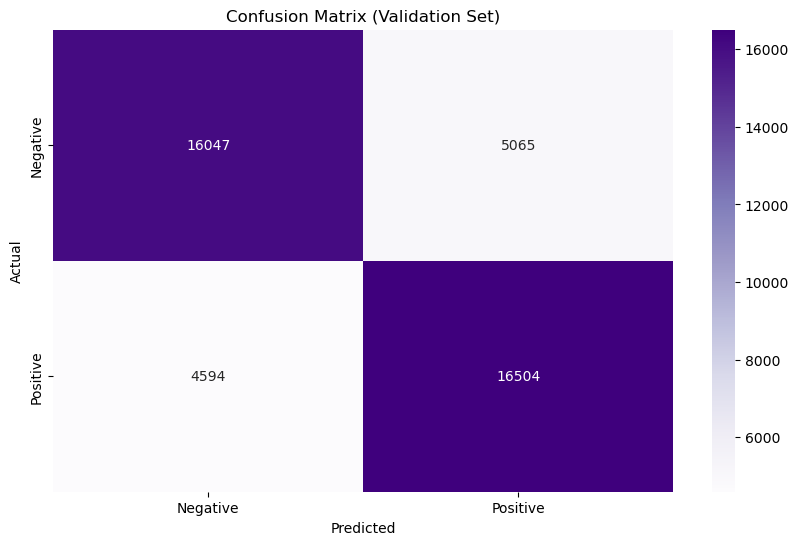

In [267]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Create a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

**2. ROC Curve (Receiver Operating Characteristic)**

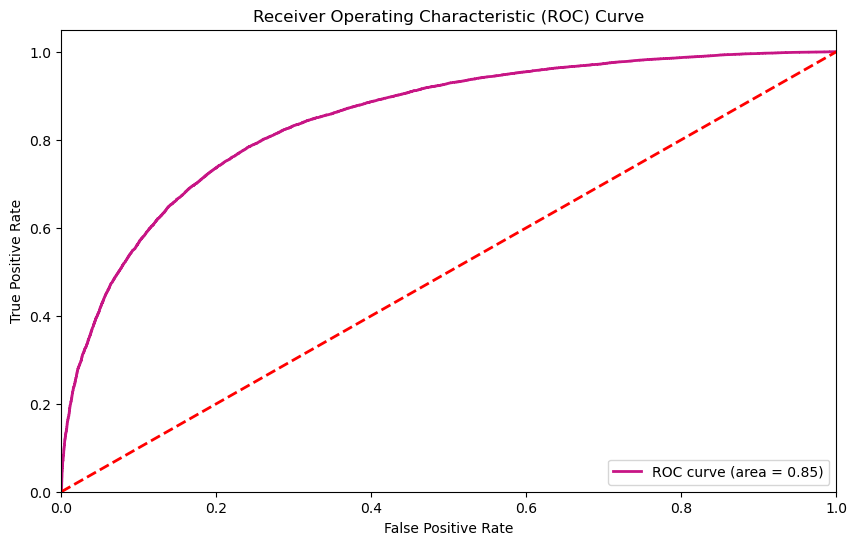

In [268]:
# Calculate True Positive Rate (TPR) & False Positive Rate (FPR)
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)

# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot for ROC Curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color="#C71585", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

**3. Learning Curve**

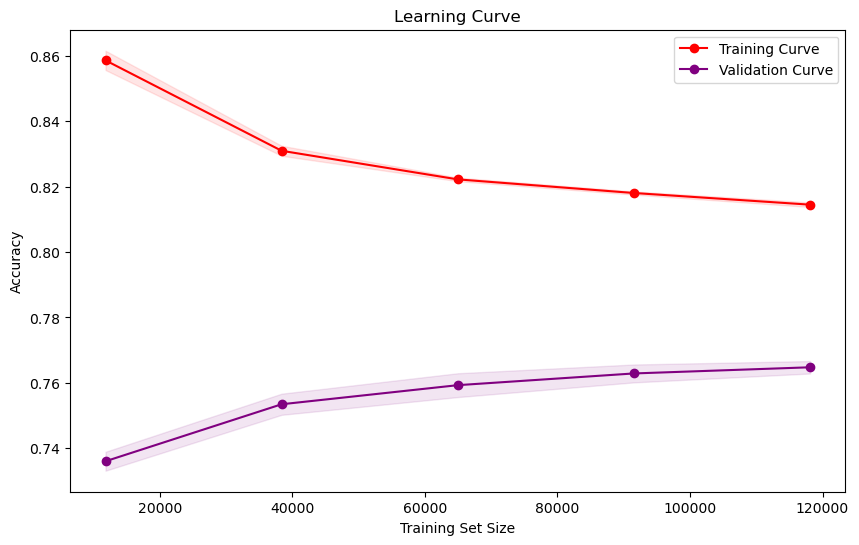

In [269]:
# Calculate learning curve
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring="accuracy")

# Calculate mean and dispersion
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, "o-", color="r", label="Training Curve")
plt.plot(train_sizes, val_mean, "o-", color="purple", label="Validation Curve")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="purple", alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

The curves show no signs of overfitting or underfitting, as the performance of the model on the training data is not too high or too low compared to the validation data. We observe that during training, the model adapts to the training data, but its performance decreases as training continues. The validation curve shows that the performance of the model on the validation data is relatively stable and slightly increases as training continues.